In [2]:
import pandas as pd
import os

In [3]:
import librosa

In [4]:
Tess = r"C:\Users\furka\Desktop\Labellenmis"

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + '\\' + dir )
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[1]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + '/' + dir  + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df)

     Emotions                                               Path
0       angry  C:\Users\furka\Desktop\Labellenmis/angry/OAF_a...
1       angry  C:\Users\furka\Desktop\Labellenmis/angry/OAF_a...
2       angry  C:\Users\furka\Desktop\Labellenmis/angry/OAF_a...
3       angry  C:\Users\furka\Desktop\Labellenmis/angry/OAF_a...
4       angry  C:\Users\furka\Desktop\Labellenmis/angry/OAF_a...
...       ...                                                ...
8975      sad  C:\Users\furka\Desktop\Labellenmis/sad/YAF_sad...
8976      sad  C:\Users\furka\Desktop\Labellenmis/sad/YAF_sad...
8977      sad  C:\Users\furka\Desktop\Labellenmis/sad/YAF_sad...
8978      sad  C:\Users\furka\Desktop\Labellenmis/sad/YAF_sad...
8979      sad  C:\Users\furka\Desktop\Labellenmis/sad/YAF_sad...

[8980 rows x 2 columns]


In [6]:
Tess_df['Emotions'].value_counts()

neutral        2108
frustration    1849
angry          1503
sad            1484
excited        1041
happy           995
Name: Emotions, dtype: int64

In [7]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [8]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(Tess_df.iterrows()):
    file_name = os.path.join(os.path.abspath(Tess),str(row["Path"]))
    final_class_labels=row["Emotions"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8980it [04:24, 33.99it/s]


In [9]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['Path','Emotions'])
extracted_features_df.head()
# Storing the dataframe to pickle for further processing
extracted_features_df.to_pickle("extracted_df.pkl")
extracted_features_df.head()

,Path,Emotions
0,"[-386.65387, 57.02423, -22.126987, -7.373469, ...",angry
1,"[-447.8823, 70.02029, -7.251139, -15.752107, -...",angry
2,"[-406.17514, 31.89866, -10.602405, 5.086764, -...",angry
3,"[-387.20657, 57.649464, -16.744616, -8.857875,...",angry
4,"[-401.65063, 56.30817, -1.0354269, 12.937799, ...",angry


In [10]:
final = pd.read_pickle("./extracted_df.pkl")
X = np.array(final["Path"].tolist())
y = np.array(final["Emotions"].tolist())

In [11]:
        import IPython.display as ipd
        import librosa
        import librosa.display
        import pandas as pd
        import os, time, warnings
        import seaborn as sns
        import numpy as np
        from tqdm import tqdm
        import matplotlib.pyplot as plt
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import LabelEncoder
        from tensorflow.keras.utils import to_categorical
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import (
            Dense,
            Conv1D,
            MaxPooling1D,
            BatchNormalization,
            Dropout, 
            Flatten,
            Conv2D,
            MaxPool2D,
        )

In [12]:
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42
)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])


Number of training samples =  8082
Number of testing samples =  898


In [14]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam

num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(2000, activation="relu", input_shape=(40,)))
ANN_Model.add(Dense(1500, activation="relu"))
ANN_Model.add(Dense(1000, activation="relu"))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(75, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))
ANN_Model.summary()

optimizer = Adam(learning_rate=0.0001)
ANN_Model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              82000     
                                                                 
 dense_1 (Dense)             (None, 1500)              3001500   
                                                                 
 dense_2 (Dense)             (None, 1000)              1501000   
                                                                 
 dense_3 (Dense)             (None, 750)               750750    
                                                                 
 dense_4 (Dense)             (None, 250)               187750    
                                                                 
 dense_5 (Dense)             (None, 100)               25100     
                                                                 
 dense_6 (Dense)             (None, 75)                7

In [15]:
ANN_Model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


In [16]:
num_epochs = 100
num_batch_size = 64

t0 = time.time()

history = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

ANN_Model.save("Model1.h5")
print("ANN Model Saved")


Epoch 1/100
127/127 [==============================] - 10s 75ms/step - loss: 1.6790 - accuracy: 0.3150 - val_loss: 1.5112 - val_accuracy: 0.3964
Epoch 2/100
127/127 [==============================] - 9s 72ms/step - loss: 1.3970 - accuracy: 0.4206 - val_loss: 1.2816 - val_accuracy: 0.4621
Epoch 3/100
127/127 [==============================] - 10s 75ms/step - loss: 1.3138 - accuracy: 0.4521 - val_loss: 1.2665 - val_accuracy: 0.4766
Epoch 4/100
127/127 [==============================] - 9s 73ms/step - loss: 1.2868 - accuracy: 0.4672 - val_loss: 1.2112 - val_accuracy: 0.5290
Epoch 5/100
127/127 [==============================] - 10s 75ms/step - loss: 1.2567 - accuracy: 0.4754 - val_loss: 1.2033 - val_accuracy: 0.4855
Epoch 6/100
127/127 [==============================] - 10s 77ms/step - loss: 1.2382 - accuracy: 0.4902 - val_loss: 1.1830 - val_accuracy: 0.5245
Epoch 7/100
127/127 [==============================] - 10s 75ms/step - loss: 1.2282 - accuracy: 0.4954 - val_loss: 1.1793 - val_accu

127/127 [==============================] - 9s 72ms/step - loss: 0.8615 - accuracy: 0.6616 - val_loss: 1.2185 - val_accuracy: 0.5479
Epoch 58/100
127/127 [==============================] - 9s 71ms/step - loss: 0.8678 - accuracy: 0.6569 - val_loss: 1.1913 - val_accuracy: 0.5601
Epoch 59/100
127/127 [==============================] - 9s 72ms/step - loss: 0.8282 - accuracy: 0.6761 - val_loss: 1.2262 - val_accuracy: 0.5535
Epoch 60/100
127/127 [==============================] - 9s 71ms/step - loss: 0.8041 - accuracy: 0.6927 - val_loss: 1.2066 - val_accuracy: 0.5624
Epoch 61/100
127/127 [==============================] - 9s 73ms/step - loss: 0.7889 - accuracy: 0.6918 - val_loss: 1.1975 - val_accuracy: 0.5546
Epoch 62/100
127/127 [==============================] - 9s 72ms/step - loss: 0.7713 - accuracy: 0.7012 - val_loss: 1.2299 - val_accuracy: 0.5523
Epoch 63/100
127/127 [==============================] - 10s 82ms/step - loss: 0.7565 - accuracy: 0.7039 - val_loss: 1.2637 - val_accuracy: 0.53

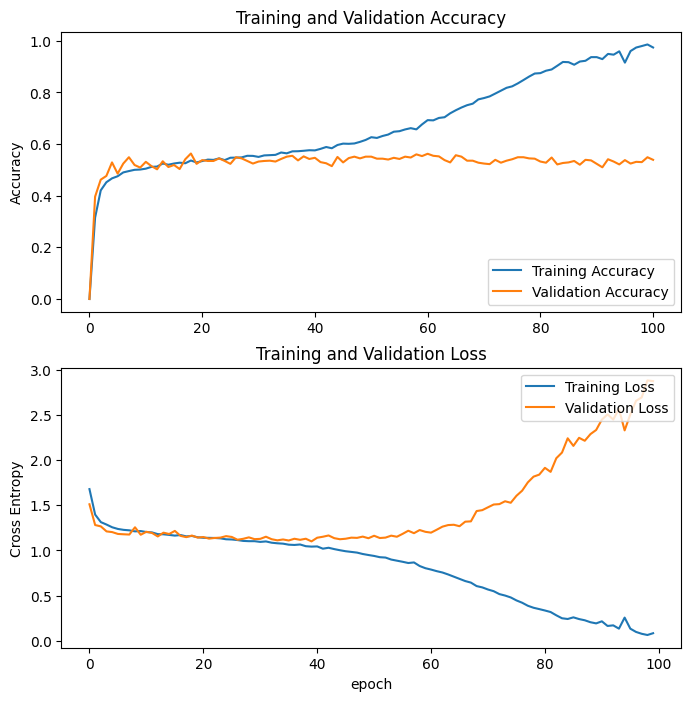

AttributeError: module 'matplotlib' has no attribute 'pyplot'

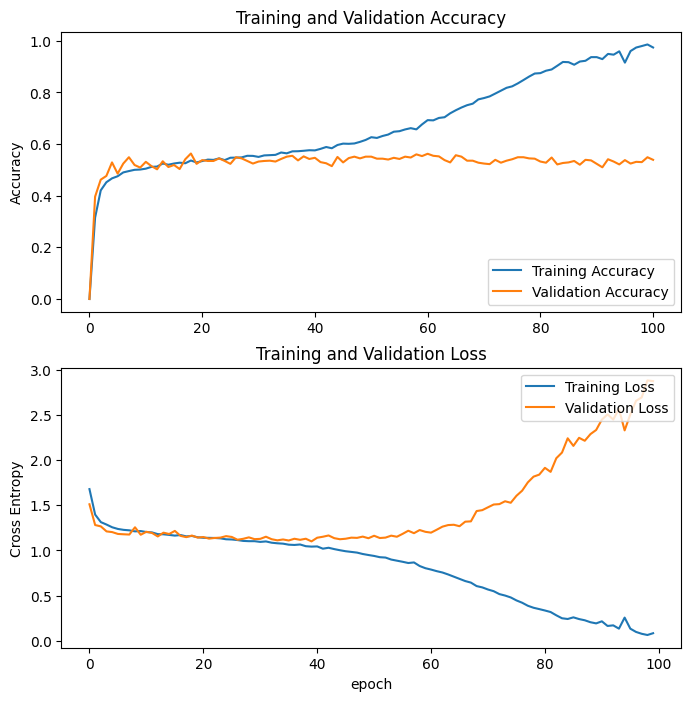

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
emotion_names=extracted_features_df['Emotions'].unique()


In [19]:
y_pred = ANN_Model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

29/29 [==============================] - 0s 8ms/step


array([3, 0, 2, 5, 4, 2, 4, 1, 3, 4, 3, 3, 5, 0, 4, 4, 2, 0, 2, 3, 4, 5,
       3, 5, 3, 4, 3, 2, 0, 0, 1, 4, 2, 5, 0, 0, 0, 5, 0, 2, 2, 4, 4, 4,
       5, 0, 2, 5, 0, 2, 2, 1, 0, 4, 3, 2, 2, 0, 5, 0, 5, 5, 5, 4, 2, 1,
       5, 4, 1, 0, 0, 4, 5, 4, 1, 4, 5, 1, 0, 4, 1, 1, 0, 4, 0, 4, 1, 3,
       4, 0, 2, 3, 1, 3, 1, 4, 4, 0, 2, 2, 2, 2, 3, 2, 3, 4, 1, 4, 4, 5,
       5, 0, 3, 1, 4, 4, 0, 5, 5, 0, 5, 2, 5, 2, 4, 1, 4, 0, 2, 3, 0, 5,
       2, 5, 4, 3, 4, 2, 3, 5, 5, 5, 2, 5, 0, 4, 0, 0, 4, 5, 5, 1, 3, 3,
       3, 3, 3, 5, 4, 1, 4, 2, 5, 1, 2, 0, 5, 0, 3, 5, 3, 3, 2, 1, 2, 5,
       2, 4, 5, 4, 4, 5, 4, 1, 1, 5, 5, 4, 2, 4, 0, 4, 5, 0, 0, 0, 4, 5,
       4, 3, 0, 5, 0, 5, 5, 1, 1, 4, 3, 2, 2, 3, 3, 3, 2, 5, 4, 5, 4, 2,
       0, 5, 1, 0, 4, 4, 2, 3, 4, 0, 5, 0, 2, 2, 2, 1, 4, 4, 2, 2, 2, 2,
       3, 0, 2, 1, 2, 5, 3, 5, 2, 4, 0, 3, 5, 5, 2, 3, 1, 5, 2, 5, 0, 5,
       0, 1, 3, 4, 2, 2, 0, 2, 5, 4, 0, 0, 2, 4, 2, 4, 4, 0, 5, 2, 4, 4,
       2, 1, 2, 4, 4, 0, 4, 0, 1, 5, 2, 4, 1, 3, 2,

In [20]:
y_check=np.argmax(y_test,axis=1)
y_check

array([3, 0, 5, 5, 0, 2, 2, 5, 4, 4, 3, 3, 2, 0, 4, 5, 2, 1, 1, 2, 3, 5,
       3, 5, 3, 4, 5, 2, 2, 0, 1, 2, 2, 5, 0, 0, 0, 5, 0, 4, 2, 1, 2, 4,
       5, 0, 4, 4, 2, 3, 4, 1, 0, 5, 2, 0, 2, 4, 5, 1, 5, 5, 4, 1, 5, 0,
       5, 4, 0, 0, 4, 4, 5, 2, 4, 4, 2, 3, 0, 2, 1, 0, 1, 1, 2, 4, 1, 3,
       4, 0, 4, 1, 4, 3, 1, 2, 3, 0, 2, 0, 2, 4, 3, 3, 1, 4, 1, 5, 4, 5,
       4, 2, 2, 3, 4, 0, 0, 5, 0, 2, 5, 2, 5, 2, 2, 0, 2, 0, 2, 0, 0, 4,
       0, 5, 2, 3, 2, 2, 3, 5, 5, 5, 1, 2, 4, 4, 0, 1, 1, 2, 5, 0, 3, 5,
       3, 1, 4, 1, 4, 4, 1, 2, 2, 3, 1, 0, 3, 2, 3, 5, 3, 4, 2, 4, 0, 2,
       2, 5, 5, 4, 4, 5, 4, 4, 1, 5, 5, 4, 4, 2, 2, 4, 3, 0, 0, 0, 4, 5,
       5, 1, 1, 5, 0, 5, 5, 2, 1, 4, 1, 5, 2, 1, 5, 3, 4, 1, 2, 2, 4, 0,
       1, 5, 3, 0, 4, 4, 0, 3, 4, 0, 5, 0, 4, 2, 0, 1, 5, 4, 2, 2, 5, 4,
       3, 4, 2, 1, 0, 5, 3, 5, 5, 3, 5, 3, 0, 5, 2, 3, 1, 4, 4, 5, 2, 4,
       1, 4, 2, 4, 4, 4, 0, 3, 5, 4, 0, 2, 2, 4, 4, 4, 1, 0, 4, 2, 4, 4,
       2, 5, 2, 2, 4, 0, 4, 2, 2, 5, 2, 4, 2, 4, 4,

In [21]:
loss,accuracy=ANN_Model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 2.8738510608673096
Test Accuracy: 0.5389754772186279


AttributeError: module 'matplotlib' has no attribute 'axes'

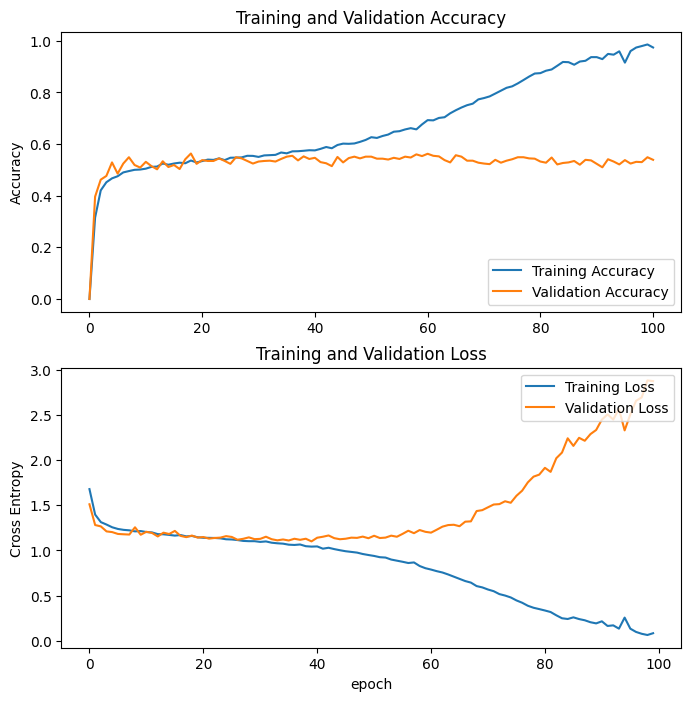

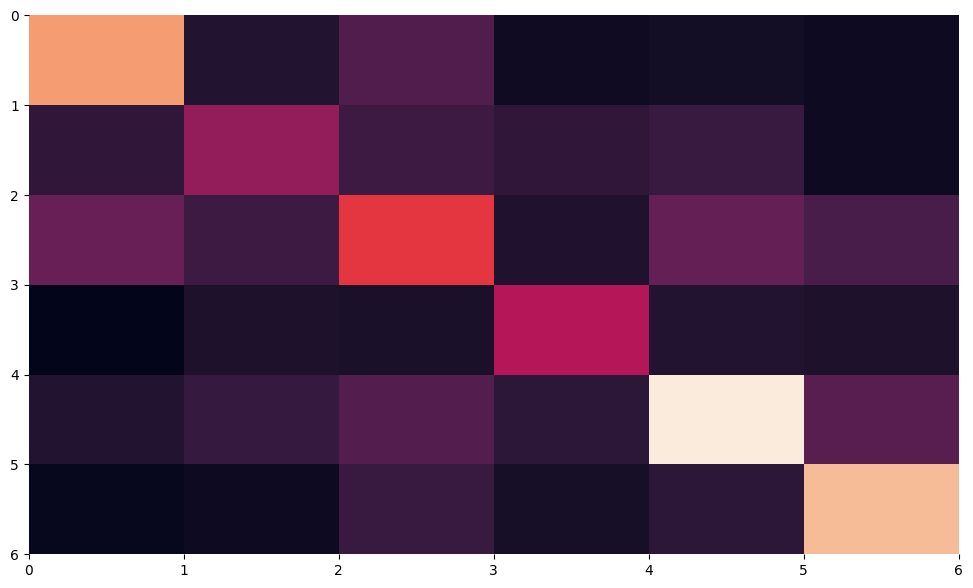

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [22]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_check, y_pred)
cm = pd.DataFrame(
    conf, index=[i for i in emotion_names], columns=[i for i in emotion_names]
)

plt.figure(figsize=(12, 7))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_title(f'Confusion Matrix for Model')
plt.show()


In [23]:
from sklearn.metrics import classification_report

print(f'Model Confusion Matrix\n', classification_report(y_check, y_pred, target_names=emotion_names))


Model Confusion Matrix
               precision    recall  f1-score   support

       angry       0.61      0.65      0.63       146
     excited       0.42      0.38      0.40       115
 frustration       0.42      0.38      0.40       184
       happy       0.51      0.59      0.55        90
     neutral       0.60      0.56      0.58       214
         sad       0.61      0.70      0.65       149

    accuracy                           0.54       898
   macro avg       0.53      0.54      0.53       898
weighted avg       0.53      0.54      0.54       898

